<a href="https://colab.research.google.com/github/AdityaMayukhSom/pytorch-loan-approval/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Credit Kaggle: [Loan Approval Prediction Dataset](https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive'

/content/drive


In [ ]:
%%capture
!pip install shap transformers

In [ ]:
import itertools, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
loan_dataset_path: str = "/content/drive/MyDrive/Datasets/loan_approval_dataset.csv"

In [ ]:
loan_df: pd.DataFrame = pd.read_csv(loan_dataset_path)
loan_df.rename(columns=lambda name: name.strip(), inplace=True)
loan_df.set_index("loan_id", inplace=True)
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4269 entries, 1 to 4269
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score               4269 non-null   int64 
 7   residential_assets_value  4269 non-null   int64 
 8   commercial_assets_value   4269 non-null   int64 
 9   luxury_assets_value       4269 non-null   int64 
 10  bank_asset_value          4269 non-null   int64 
 11  loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 433.6+ KB


In [ ]:
loan_df["education"] = loan_df["education"].str.strip()
loan_df["self_employed"] = loan_df["self_employed"].str.strip()

loan_df["loan_status"] = (loan_df["loan_status"] == "Approved").astype(int)
loan_df["education"] = (loan_df["education"] == "Graduate").astype(int)
loan_df["self_employed"] = (loan_df["self_employed"] == "Yes").astype(int)

In [ ]:
def show_histogram():
    for feature in loan_df.columns[:-1]:
        plt.hist(
            loan_df[loan_df["loan_status"] == 1][feature],
            color="blue",
            label="Accepted",
            alpha=0.7,
            density=True,
        )
        plt.hist(
            loan_df[loan_df["loan_status"] == 0][feature],
            color="red",
            label="Rejected",
            alpha=0.7,
            density=True,
        )
        plt.title(feature)
        plt.xlabel(feature)
        plt.ylabel("Probability")
        plt.legend()
        plt.show()

In [ ]:
def show_pair_plot():
    sns.pairplot(loan_df, hue='loan_status')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
X = loan_df[loan_df.columns[:-1]].values
y = loan_df[loan_df.columns[-1]].values
standard_scalar = StandardScaler()
X = standard_scalar.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=69, test_size=0.3, shuffle=True
)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float64))
        self.y = torch.from_numpy(y.astype(np.float64))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len


In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(MultiLayerPerceptron, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.layer1 = nn.Linear(input_dim, hidden_dim, dtype=torch.float64)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim, dtype=torch.float64)
        self.act2 = nn.Sigmoid()
        nn.init.kaiming_uniform_(self.layer1.weight, nonlinearity="relu")
        nn.init.normal_(self.layer2.weight)

    def forward(self, x):
        x = self.dropout(x)
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        return x

In [ ]:
# Helper function to train the model and return the validation result
def model_train(model, train_dataloader, device, num_epochs=50, learning_rate=0.01) -> tuple[list[float], list[float]]:
    accuracy_values, loss_values = [], []
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        loss_for_epoch = 0
        correct_for_epoch = 0
        for batch, (X_train_batch, y_train_batch) in enumerate(train_dataloader):
            X_train_batch = X_train_batch.to(device)
            y_train_batch = y_train_batch.to(device)

            optimizer.zero_grad()
            y_pred_batch = model(X_train_batch)

            loss = loss_fn(y_pred_batch, y_train_batch.unsqueeze(-1))
            loss_for_epoch += loss.item()
            correct_for_epoch += math.floor(
                torch.sum(
                    torch.where(y_pred_batch < 0.5, 0, 1).view(-1) == y_train_batch.view(-1)
                ).item()
            )

            loss.backward()
            optimizer.step()

        # adds the total average loss for one epoch into loss_values
        loss_values.append(loss_for_epoch / train_dataloader.batch_size)
        accuracy = correct_for_epoch / train_dataloader.dataset.len
        accuracy_values.append(accuracy)

    return accuracy_values, loss_values

In [ ]:
def model_evaluate(model, test_dataloader, device) -> float:
    '''The model needs to be in the same device too.'''
    model.eval() # evaluate accuracy after training
    correct: int = 0 # stores the number of correct response given by the model

    with torch.no_grad():
        for batch, (X_test_batch, y_test_batch) in enumerate(test_dataloader):
            X_test_batch = torch.Tensor(X_test_batch.to(device))
            y_test_batch = torch.Tensor(y_test_batch.to(device))

            outputs = model(X_test_batch)
            predicted = torch.where(outputs < 0.5, 0, 1)

            # Ensure predicted and y_test_batch have the same shape and data type
            # without view conversion, broadcasting happens which produces a new tensor
            # of size [batch_size x batch_size] which does not correspond to the tensor
            # containing True where values match and False where values mismatch.
            # item() is used to convert torch.Tensor type to a scalar numerical value.
            correct += math.floor(torch.sum(predicted.view(-1) == y_test_batch.view(-1)).item())

    accuracy: float = correct / test_dataloader.dataset.len
    return accuracy

In [ ]:
batch_size = 64
num_epochs = 120

In [ ]:
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([64, 11])
y shape: torch.Size([64])


In [ ]:
# create model, train, and get accuracy
model = MultiLayerPerceptron(11, 1, 32).to(device)
accuracy_values, loss_values = model_train(model, train_dataloader, device, num_epochs=num_epochs)
accuracy = model_evaluate(model, test_dataloader, device)
print("Accuracy: %.2f" % accuracy)

Accuracy: 0.94


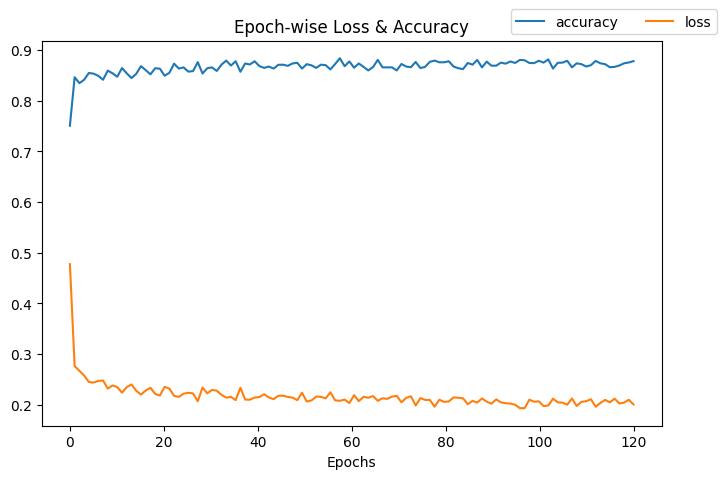

In [ ]:
accuracy_values = np.array(accuracy_values)
loss_values = np.array(loss_values)
step = np.linspace(0, num_epochs, len(loss_values))

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(step, accuracy_values)
ax.plot(step, loss_values)
ax.set_title("Epoch-wise Loss & Accuracy")
ax.set_xlabel("Epochs")
ax.legend(["accuracy", "loss"], bbox_to_anchor=(1.1, 1.1), ncol=2)

plt.show()

In [ ]:
y_pred = model.